# Understanding SHAP by fitting more SHAPs!
(using stratified 5-fold cross validation, and a model with 8 features)

## Plain English summary

From the XGBoost model fitted to 0fold data, get a SHAP value for the hospital that the patient attended. What does this hospital SHAP value show? Are there any relationships (reasons) between this value and the valuesof the features for that patient? For example, for this particular hosptial that has a patient with a severe stroke and prior disability, how does this hospital act? 

If fit a XGBoost model of these feature valeus to the hostpial SHAP value, then the SHAP values for hte features show how they contribute to getting the SHAP - help to unpick any relationships between teh feature values and the hostpial SHAP for that patient.

## Model and data

XGBoost models were trained on stratified k-fold cross-validation data. The 8 features in the model are:

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (1 = Yes, 0 = No)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)
* Thrombolysis use: Stroke team attended

And one target feature:
* Mean SHAP values for the hospital one-hot encoded feature that the patient attended, from the 0fold model.

## Aims

* Fit XGBoost model using feature data to predict SHAP value, a model per hospital
* Or a model for the 30 bottom hosptials

## Observations

* Fitting to all 30 bottom hospitals in one model gave R2 of ~0.3
* Fitting to a single hospital gave R2 of ~0.8.
* Fitting a model to each hospital, and collating all of the values for the observed and the predicted when the instance is in the test set (so get an observed and predicted value for each instance when it exists in the test set). Gave R2 of 0.951
* Analyse the SHAP of the features. Do this per hosptial, as each hosptial has a different pattern.

## Import libraries

In [154]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

#from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.linear_model import LinearRegression
from sklearn import metrics

from scipy.stats import linregress
import shap
from imblearn.over_sampling import RandomOverSampler

import json

from sklearn.model_selection import StratifiedKFold

## Set modifications to apply

In [144]:
use_minority_oversampling = False

# Set model type (used in file save, e.g. xgb_combined_calibrated_oversampled)
model_type = 'xgb_combined_key_features'

## Create output folders if needed

In [145]:
path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)

## Load data

Data has previously been split into 5 stratified k-fold splits.

In [146]:
# Read in thrombolysis rate on 10K cohort
feature_data_with_shap = pd.read_csv(
    './predictions/feature_data_with_hospital_shap.csv')

In [147]:
feature_data_with_shap

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Stroke team,Use of AF anticoagulents,Onset-to-arrival time,Thrombolysis,Hospital_SHAP
0,1.0,0,10.0,1,2,AGNOF1041H,0,190.0,0,0.095683
1,1.0,1,17.0,1,0,AGNOF1041H,0,119.0,1,-0.042648
2,2.0,1,15.0,0,4,AGNOF1041H,0,64.0,0,-0.174697
3,2.0,1,4.0,1,1,AGNOF1041H,0,120.0,0,-0.089601
4,8.0,1,12.0,1,2,AGNOF1041H,0,82.0,1,-0.050211
...,...,...,...,...,...,...,...,...,...,...
17754,34.0,1,10.0,1,2,ZRRCV7012C,0,119.0,0,-0.627209
17755,31.0,1,4.0,0,1,ZRRCV7012C,1,50.0,0,-0.433139
17756,1.0,1,5.0,1,3,ZRRCV7012C,0,73.0,0,-0.228851
17757,58.0,1,16.0,0,2,ZRRCV7012C,0,144.0,0,-0.761119


## Functions

Calculate r squared

In [148]:
def calc_r_squared(y_test, y_pred):
    slope, intercept, r_value, p_value, std_err = linregress(y_test, y_pred)
    r_squared = r_value**2
    return(r_squared)

Plot scatter: observed vs predicted

In [149]:
def plot_observed_predicted(y_test, y_pred, r_squared):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot()
    ax.scatter(y_test, y_pred)
    ax.set_xlabel('Observed')
    ax.set_ylabel('Predicted')
    ax.set_title(f'XG-Boost regression of hospital feature SHAP\nR-squared: {r_squared:0.3f}')
    return()

## Fit model

XGBoost models were trained on stratified k-fold cross-validation data.

Report r-squared of observed vs predicted.

In [157]:
# Set up list to store models and calibarion threshold
models = []

# Set up lists for observed and predicted
observed = []
predicted = []
hospital_instances = []
model_description = []
shap_values_extended_list = []
shap_values_list = []

for hospital in thrombolysis_by_hosp.index:

    # Extract the data for this single hospital
    mask = feature_data_with_shap["Stroke team"] == hospital
    data = feature_data_with_shap[mask]
    data.drop(["Stroke team"], axis=1, inplace=True)
    hospital_instances.append(data.shape[0])
#    print(f"Hospital {hospital} has {data.shape[0]} instances")
    

    # Set up list for feature importances
#    feature_importance = []

    # Initialise empty lists
    train_data, test_data = [], []

    # Set up splits
    number_of_splits = 5
    skf = StratifiedKFold(n_splits = number_of_splits, shuffle=True, random_state=13)
    strat = data['Thrombolysis'].map(str)# + '-' + data['Hospital_SHAP'].map(str)
# ValueError: n_splits=5 cannot be greater than the number of members in each class.

    skf.get_n_splits(data, strat.values)

    # Put in NumPy arrays
    X = data.values
    y = strat.values
    X_col_names = list(data)

    # Loop through the k-fold splits
    counter = 0
    for train_index, test_index in skf.split(X, y):  

        # Get Xtrain and test
        train_np, test_np = X[train_index], X[test_index]

        # Convert to Pandas DataFrames
        train = pd.DataFrame(train_np, columns=X_col_names)
        test = pd.DataFrame(test_np, columns=X_col_names)

        # Get X and y
        X_train = train.drop("Hospital_SHAP", axis=1)
        X_test = test.drop("Hospital_SHAP", axis=1)
        y_train = train["Hospital_SHAP"]
        y_test = test["Hospital_SHAP"]

    #    # Use oversampling if required
    #    if use_minority_oversampling:
    #        oversample = RandomOverSampler(sampling_strategy='minority')
    #        X_train, y_train = oversample.fit_resample(X_train, y_train)        

    #    # One hot encode hospitals
    #    X_train_hosp = pd.get_dummies(X_train['Stroke team'], prefix = 'team')
    #    X_train = pd.concat([X_train, X_train_hosp], axis=1)
    #    X_train.drop('Stroke team', axis=1, inplace=True)
    #    X_test_hosp = pd.get_dummies(X_test['Stroke team'], prefix = 'team')
    #    X_test = pd.concat([X_test, X_test_hosp], axis=1)
    #    X_test.drop('Stroke team', axis=1, inplace=True)    

        # Define model
        model = XGBRegressor()
        
    #    # Define model
    #    model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)

        # Fit model
        model.fit(X_train, y_train)
        models.append(model)
        model_description.append(hospital + "_" + str(counter))
        # Get predicted probabilities
        y_pred = model.predict(X_test)
    #    y_probs = model.predict_proba(X_test)[:,1]
    
        # Store the test values: observed and predicted
        # Means each instance will be stored as a predicted value when in the 
        # test set
        observed.append(y_test)
        predicted.append(y_pred)

    #    # Get feature importances
    #    importance = model.feature_importances_
    #    feature_importance.append(importance)
    
    
    
        # Set up explainer using the model and feature values from training set
        explainer = shap.TreeExplainer(model, X_train)

        # Get (and store) Shapley values along with base and feature values
        shap_values_extended = explainer(X_test)
        shap_values_extended_list.append(shap_values_extended)
        # Shap values exist for each classification in a Tree
        # We are interested in 1=give thrombolysis (not 0=not give thrombolysis)
        shap_values = shap_values_extended.values
        shap_values_list.append(shap_values)        

#        # Save using pickle
#        filename = f'./output/shap_values_extended_xgb_key_features_{k}.p'
#        with open(filename, 'wb') as filehandler:
#            pickle.dump(shap_values_extended, filehandler)
#        
#        # Print progress
#        print (f'Completed {k+1} of 5')

        counter += 1

# Print performance (r-squared)
observed_flatten = [x for xs in observed for x in xs]
predicted_flatten = [x for xs in predicted for x in xs]
r_squared = calc_r_squared(observed_flatten, predicted_flatten)
print (
    f'All kfolds for all hospitals. R-squared: {r_squared:0.3f}')



All kfolds for all hospitals. R-squared: 0.951


### Plot XGBoost regression of SHAP

()

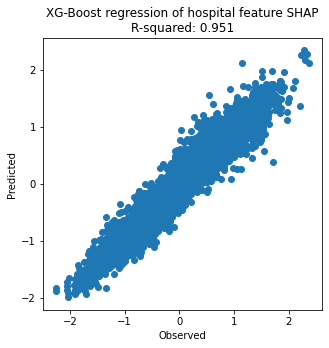

In [158]:
plot_observed_predicted(observed_flatten, predicted_flatten, r_squared)

### Histogram of number of instances per hospital

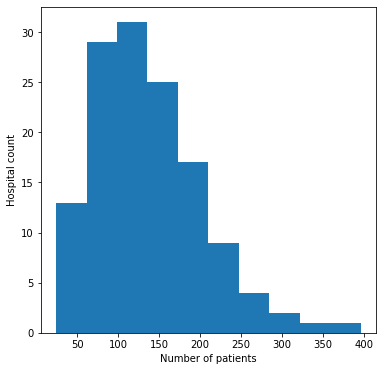

In [159]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.hist(hospital_instances)#, bins=np.arange(0.10, 0.46, 0.025))
ax.set_xlabel('Number of patients')
ax.set_ylabel('Hospital count')
plt.show()

In [160]:
for hospital in range():
    for i in range(5): # going through each batch of 5 kfolds for a hospital

        len(shap_values_extended_list)


660

## Identify 30 hospitals with lowest thrombolysis rate on 10K patient cohort

# Read data and rank on thrombolysis rate
thrombolysis_by_hosp = pd.read_csv(
    './output/10k_thrombolysis_rate_by_hosp_key_features.csv', index_col='stroke_team')

thrombolysis_by_hosp.sort_values(
    'Thrombolysis rate', ascending=False, inplace=True)

# Take 30 hospitals with lowest thrombolysis rates
bottom_30_hospitals = list(thrombolysis_by_hosp.tail(30).index)

## Restrict dataset to bottom 30 hosptials (based on thrombolysis rate on 10K cohort)
# And remove "Stroke team" from the dataset. Fit the data without information of which hospital.

mask = feature_data_with_shap["Stroke team"].isin(bottom_30_hospitals)
feature_data_with_shap_bottom30 = feature_data_with_shap[mask]
feature_data_with_shap_bottom30.drop(["Stroke team"], axis=1, inplace=True)
data = feature_data_with_shap_bottom30
print(f"Data has {data.shape[0]} instances")

## Create stratification based on ??? (it was hospital and thrombolysis use?)

This time use S2Thrombolysis, and see if cts works and if so use SHAP

In [86]:
#strat = SHAP #data['StrokeTeam'].map(str) + '-' + data['S2Thrombolysis'].map(str)
strat = data['Thrombolysis'].map(str)

## Create and save five k-fold splits

In [87]:
#load_splits = False

# Initialise empty lists
train_data, test_data = [], []


# Set up splits
number_of_splits = 5
skf = StratifiedKFold(n_splits = number_of_splits, shuffle=True, random_state=13)
skf.get_n_splits(data, strat.values)

# Put in NumPy arrays
X = data.values
y = strat.values
X_col_names = list(data)

# Loop through the k-fold splits
counter = 0
for train_index, test_index in skf.split(X, y):  
    
    # Get Xtrain and test
    train_np, test_np = X[train_index], X[test_index]
    
    # Convert to Pandas DataFrames
    train = pd.DataFrame(train_np, columns=X_col_names)
    test = pd.DataFrame(test_np, columns=X_col_names)

    train_data.append(train)
    test_data.append(test)    

    # Save no unit encoding dataset
#    train.to_csv(f'{output_dir}/train_SHAP_{counter}.csv', index=False)
#    test.to_csv(f'{output_dir}/test_SHAP_{counter}.csv', index=False)
    
#    # One hot encode stroke team
#    units = train['StrokeTeam']
#    train.drop(['StrokeTeam'],inplace=True, axis=1)
#    one_hot_coded = pd.get_dummies(units, prefix='StrokeTeam')
#    train = pd.concat([train, one_hot_coded], axis=1)
#    train.to_csv(f'{output_dir}/train_one_hot_unit_{counter}.csv', index=False)
    
#    units = test['StrokeTeam']
#    test.drop(['StrokeTeam'],inplace=True, axis=1)
#    one_hot_coded = pd.get_dummies(units, prefix='StrokeTeam')
#    test = pd.concat([test, one_hot_coded], axis=1)
#    test.to_csv(f'{output_dir}/test_one_hot_unit_{counter}.csv', index=False)
    
    # Increment counter
    counter += 1
    
    
# read in splits    
#for i in range(5):
#    train = pd.read_csv(data_loc + 'train_SHAP_{0}.csv'.format(i))
#    train_data.append(train)
#    test = pd.read_csv(data_loc + 'test_SHAP_{0}.csv'.format(i))
#    test_data.append(test)

## Fit model

XGBoost models were trained on stratified k-fold cross-validation data.

Report r-squared of observed vs predicted.

In [88]:
def calc_r_squared(y_test, y_pred):
    slope, intercept, r_value, p_value, std_err = linregress(y_test, y_pred)
    r_squared = r_value**2
    return(r_squared)

In [89]:
def plot_observed_predicted(y_test, y_pred, r_squared):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot()
    ax.scatter(y_test, y_pred)
    ax.set_xlabel('Observed')
    ax.set_ylabel('Predicted')
    ax.set_title(f'XG-Boost regression of hospital feature SHAP\nR-squared: {r_squared:0.3f}')
    return()

Run 0, R-squared: 0.569
Run 1, R-squared: 0.818
Run 2, R-squared: 0.814
Run 3, R-squared: 0.778
Run 4, R-squared: 0.850


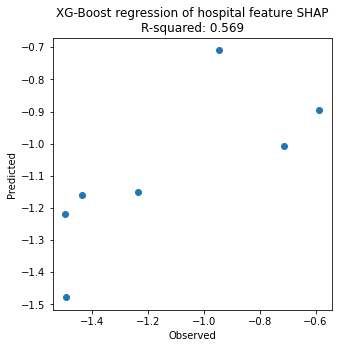

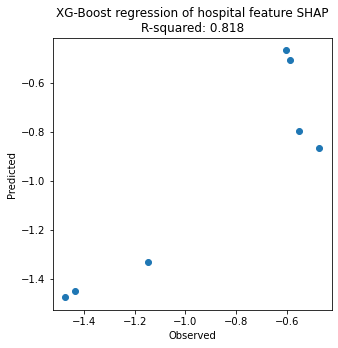

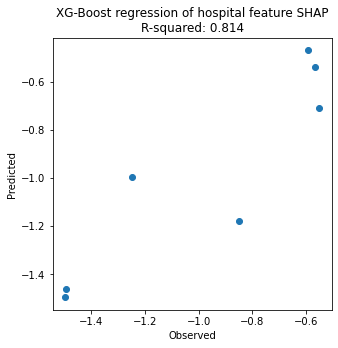

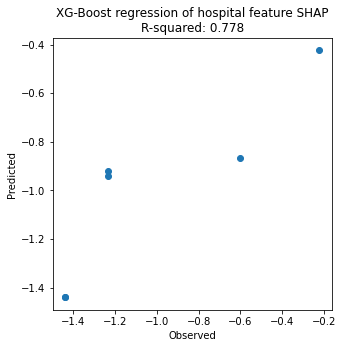

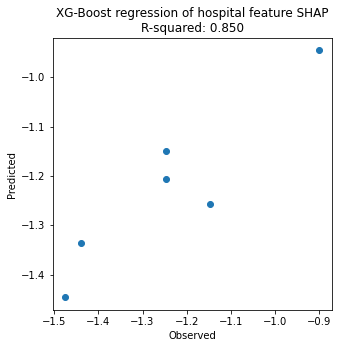

In [90]:
# Set up list to store models and calibarion threshold
models = []

# Set up lists for observed and predicted
observed = []
predicted = []

# Set up list for feature importances
feature_importance = []

# Loop through k folds
for k_fold in range(5):
    
    # Get k fold split
    train = train_data[k_fold]
    test = test_data[k_fold]
    
    # Get X and y
    X_train = train.drop("Hospital_SHAP", axis=1)
    X_test = test.drop("Hospital_SHAP", axis=1)
    y_train = train["Hospital_SHAP"]
    y_test = test["Hospital_SHAP"]
    
#    # Use oversampling if required
#    if use_minority_oversampling:
#        oversample = RandomOverSampler(sampling_strategy='minority')
#        X_train, y_train = oversample.fit_resample(X_train, y_train)        
    
#    # One hot encode hospitals
#    X_train_hosp = pd.get_dummies(X_train['Stroke team'], prefix = 'team')
#    X_train = pd.concat([X_train, X_train_hosp], axis=1)
#    X_train.drop('Stroke team', axis=1, inplace=True)
#    X_test_hosp = pd.get_dummies(X_test['Stroke team'], prefix = 'team')
#    X_test = pd.concat([X_test, X_test_hosp], axis=1)
#    X_test.drop('Stroke team', axis=1, inplace=True)    
    
    # Define model
    model = XGBRegressor()
#    # Define model
#    model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)
    
    # Fit model
    model.fit(X_train, y_train)
    models.append(model)
    
    # Get predicted probabilities
    y_pred = model.predict(X_test)
#    y_probs = model.predict_proba(X_test)[:,1]
    observed.append(y_test)
    predicted.append(y_pred)
    
#    # Get feature importances
#    importance = model.feature_importances_
#    feature_importance.append(importance)
    
    # Print performance (r-squared)
    r_squared = calc_r_squared(y_test, y_pred)
    print (
        f'Run {k_fold}, R-squared: {r_squared:0.3f}')

    # Plot XGBoost regression of SHAP
    plot_observed_predicted(y_test, y_pred, r_squared)

All kfolds for all hospitals. R-squared: 0.951


()

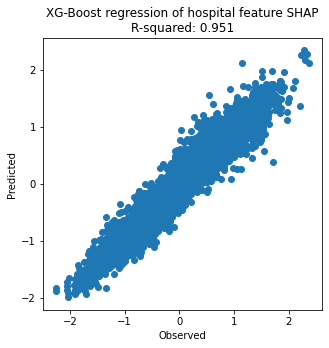

In [136]:
# Set up list to store models and calibarion threshold
models = []

# Set up lists for observed and predicted
observed = []
predicted = []
hospital_instances = []

for hospital in thrombolysis_by_hosp.index:

    # Extract the data for this single hospital
    mask = feature_data_with_shap["Stroke team"] == hospital
    data = feature_data_with_shap[mask]
    data.drop(["Stroke team"], axis=1, inplace=True)
    hospital_instances.append(data.shape[0])
#    print(f"Hospital {hospital} has {data.shape[0]} instances")
    

    # Set up list for feature importances
#    feature_importance = []

    # Initialise empty lists
    train_data, test_data = [], []

    # Set up splits
    number_of_splits = 5
    skf = StratifiedKFold(n_splits = number_of_splits, shuffle=True, random_state=13)
    strat = data['Thrombolysis'].map(str)
    skf.get_n_splits(data, strat.values)

    # Put in NumPy arrays
    X = data.values
    y = strat.values
    X_col_names = list(data)

    # Loop through the k-fold splits
    counter = 0
    for train_index, test_index in skf.split(X, y):  

        # Get Xtrain and test
        train_np, test_np = X[train_index], X[test_index]

        # Convert to Pandas DataFrames
        train = pd.DataFrame(train_np, columns=X_col_names)
        test = pd.DataFrame(test_np, columns=X_col_names)

        counter += 1

        # Get X and y
        X_train = train.drop("Hospital_SHAP", axis=1)
        X_test = test.drop("Hospital_SHAP", axis=1)
        y_train = train["Hospital_SHAP"]
        y_test = test["Hospital_SHAP"]

    #    # Use oversampling if required
    #    if use_minority_oversampling:
    #        oversample = RandomOverSampler(sampling_strategy='minority')
    #        X_train, y_train = oversample.fit_resample(X_train, y_train)        

    #    # One hot encode hospitals
    #    X_train_hosp = pd.get_dummies(X_train['Stroke team'], prefix = 'team')
    #    X_train = pd.concat([X_train, X_train_hosp], axis=1)
    #    X_train.drop('Stroke team', axis=1, inplace=True)
    #    X_test_hosp = pd.get_dummies(X_test['Stroke team'], prefix = 'team')
    #    X_test = pd.concat([X_test, X_test_hosp], axis=1)
    #    X_test.drop('Stroke team', axis=1, inplace=True)    

        # Define model
        model = XGBRegressor()
    #    # Define model
    #    model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)

        # Fit model
        model.fit(X_train, y_train)
        models.append(model)

        # Get predicted probabilities
        y_pred = model.predict(X_test)
    #    y_probs = model.predict_proba(X_test)[:,1]
    
        # Store the test values: observed and predicted
        # Means each instance will be stored as a predicted value when in the 
        # test set
        observed.append(y_test)
        predicted.append(y_pred)

    #    # Get feature importances
    #    importance = model.feature_importances_
    #    feature_importance.append(importance)

# Print performance (r-squared)

observed_flatten = [x for xs in observed for x in xs]
predicted_flatten = [x for xs in predicted for x in xs]
r_squared = calc_r_squared(observed_flatten, predicted_flatten)
print (
    f'All kfolds for all hospitals. R-squared: {r_squared:0.3f}')

# Plot XGBoost regression of SHAP
plot_observed_predicted(observed_flatten, predicted_flatten, r_squared)

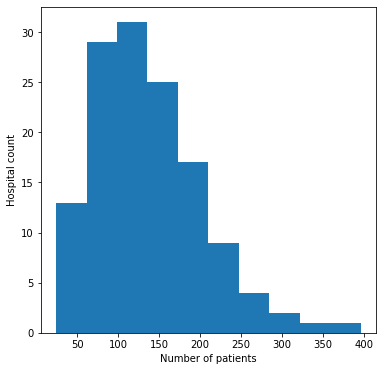

In [137]:
# Histogram of number of instances per hospital
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.hist(hospital_instances)#, bins=np.arange(0.10, 0.46, 0.025))
ax.set_xlabel('Number of patients')
ax.set_ylabel('Hospital count')
plt.show()

# KP STOP HERE. REGROUP!

### Collate and save results 

In [17]:
hospital_results = []
kfold_result = []
observed_results = []
prob_results = []
predicted_results = []

for i in range(5):
    hospital_results.extend(list(test_data[i]['Stroke team']))
    kfold_result.extend(list(np.repeat(i, len(test_data[i]))))
    observed_results.extend(list(observed[i]))
    prob_results.extend(list(predicted_proba[i]))
    predicted_results.extend(list(predicted[i]))    
    
model_predictions = pd.DataFrame()
model_predictions['hospital'] = hospital_results
model_predictions['observed'] = np.array(observed_results) * 1.0
model_predictions['prob'] = prob_results
model_predictions['predicted'] = predicted_results
model_predictions['k_fold'] = kfold_result
model_predictions['correct'] = model_predictions['observed'] == model_predictions['predicted']

# Save
filename = f'./predictions/{model_type}_predictions.csv'
model_predictions.to_csv(filename, index=False)

# Save combined test set
combined_test_set = pd.concat(test_data, axis=0)
combined_test_set.reset_index(inplace=True); del combined_test_set['index']
combined_test_set.to_csv(f'./predictions/{model_type}_combined_test_features.csv')

## Compare predicted and actual thrombolysis rates

In [18]:
mean_results_by_hosp  = model_predictions.groupby('hospital').mean()

Get r-square of predicted thrombolysis rate.

In [19]:
x_comparision = np.array(mean_results_by_hosp['observed']).reshape(-1, 1)
y_comparision = np.array(mean_results_by_hosp['predicted']).reshape(-1, 1)

slr = LinearRegression()
slr.fit(x_comparision, y_comparision)
y_pred = slr.predict(x_comparision)
r_square = metrics.r2_score(y_comparision, y_pred)

print(f'R squared {r_square:0.3f}')

R squared 0.966


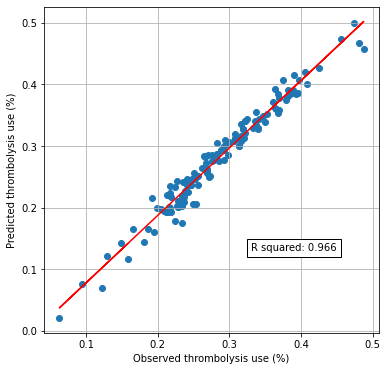

In [20]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.scatter(x_comparision,
            y_comparision)

plt.plot (x_comparision, slr.predict(x_comparision), color = 'red')
text = f'R squared: {r_square:.3f}'
ax1.text(0.33,0.13, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
ax1.set_xlabel('Observed thrombolysis use (%)')
ax1.set_ylabel('Predicted thrombolysis use (%)')
plt.grid()
plt.savefig(f'output/{model_type}_observed_predicted_rates.jpg', dpi=300)
plt.show()

## Feature Importances

Get XGBoost feature importances (average across k-fold results)

In [21]:
# Feature names
features = X_test.columns.values

# Get average feature importance from k-fold
importances = np.array(feature_importance).mean(axis = 0)
feature_importance = pd.DataFrame(data = importances, index=features)
feature_importance.columns = ['importance']

# Sort by importance (weight)
feature_importance.sort_values(by='importance', ascending=False, inplace=True)

# Save
feature_importance.to_csv(f'output/{model_type}_feature_importance.csv')

# Display top 25
feature_importance.head(25)

,importance
Infarction,0.351191
Use of AF anticoagulents,0.047361
Precise onset time,0.028215
team_MHMYL4920B,0.012756
Stroke severity,0.012489
Prior disability level,0.011771
team_GKONI0110I,0.011207
Arrival-to-scan time,0.011024
team_XKAWN3771U,0.010322
team_LECHF1024T,0.010216


Create a bar chart for the XGBoost feature importance values

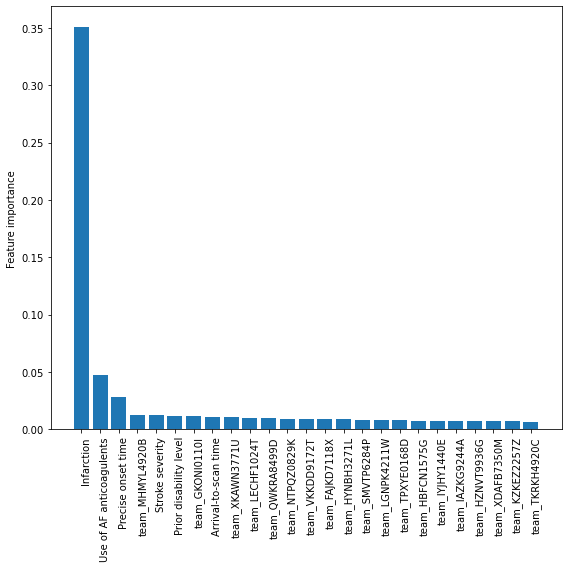

In [22]:
# Set up figure
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

# Get labels and values
labels = feature_importance.index.values[0:25]
pos = np.arange(len(labels))
val = feature_importance['importance'].values[0:25]

# Plot
ax.bar(pos, val)
ax.set_ylabel('Feature importance')
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

plt.tight_layout()
plt.savefig(f'output/{model_type}_feature_weights_bar.jpg', dpi=300)
plt.show()

## Calibration and assessment of accuracy when model has high confidence

In [23]:
# Collate results in Dataframe
reliability_collated = pd.DataFrame()

# Loop through k fold predictions
for i in range(5):
    
    # Get observed class and predicted probability
    obs = observed[i]
    prob = predicted_proba[i]
    
    # Bin data with numpy digitize (this will assign a bin to each case)
    step = 0.10
    bins = np.arange(step, 1+step, step)
    digitized = np.digitize(prob, bins)
        
    # Put single fold data in DataFrame
    reliability = pd.DataFrame()
    reliability['bin'] = digitized
    reliability['probability'] = prob
    reliability['observed'] = obs
    classification = 1 * (prob > 0.5 )
    reliability['correct'] = obs == classification
    reliability['count'] = 1
    
    # Summarise data by bin in new dataframe
    reliability_summary = pd.DataFrame()

    # Add bins and k-fold to summary
    reliability_summary['bin'] = bins
    reliability_summary['k-fold'] = i

    # Calculate mean of predicted probability of thrombolysis in each bin
    reliability_summary['confidence'] = \
        reliability.groupby('bin').mean()['probability']

    # Calculate the proportion of patients who receive thrombolysis
    reliability_summary['fraction_positive'] = \
        reliability.groupby('bin').mean()['observed']
    
    # Calculate proportion correct in each bin
    reliability_summary['fraction_correct'] = \
        reliability.groupby('bin').mean()['correct']
    
    # Calculate fraction of results in each bin
    reliability_summary['fraction_results'] = \
        reliability.groupby('bin').sum()['count'] / reliability.shape[0]   
    
    # Add k-fold results to DatafRame collation
    reliability_collated = reliability_collated.append(reliability_summary)
    
# Get mean results
reliability_summary = reliability_collated.groupby('bin').mean()
reliability_summary.drop('k-fold', axis=1, inplace=True)

In [24]:
reliability_summary

,confidence,fraction_positive,fraction_correct,fraction_results
bin,,,,
0.1,0.018412,0.023867,0.976133,0.472306
0.2,0.145836,0.164487,0.835513,0.086280
0.3,0.247578,0.271592,0.728408,0.058316
0.4,0.349648,0.367141,0.632859,0.047853
0.5,0.448994,0.444480,0.555520,0.042402
0.6,0.550910,0.546004,0.546004,0.043506
0.7,0.652850,0.635854,0.635854,0.051615
0.8,0.752323,0.747044,0.747044,0.064285
0.9,0.851260,0.824061,0.824061,0.085334


Plot results:

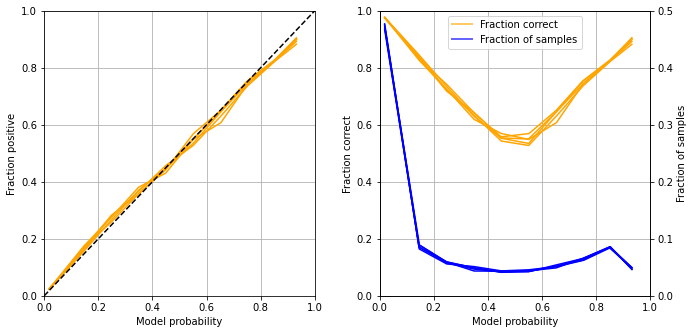

In [25]:
fig = plt.figure(figsize=(10,5))

# Plot predicted prob vs fraction psotive
ax1 = fig.add_subplot(1,2,1)

# Loop through k-fold reliability results
for i in range(5):
    mask = reliability_collated['k-fold'] == i
    k_fold_result = reliability_collated[mask]
    x = k_fold_result['confidence']
    y = k_fold_result['fraction_positive']
    ax1.plot(x,y, color='orange')
# Add 1:1 line
ax1.plot([0,1],[0,1], color='k', linestyle ='--')
# Refine plot
ax1.set_xlabel('Model probability')
ax1.set_ylabel('Fraction positive')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

# Plot accuracy vs probability
ax2 = fig.add_subplot(1,2,2)
# Loop through k-fold reliability results
for i in range(5):
    mask = reliability_collated['k-fold'] == i
    k_fold_result = reliability_collated[mask]
    x = k_fold_result['confidence']
    y = k_fold_result['fraction_correct']
    ax2.plot(x,y, color='orange')
# Refine plot
ax2.set_xlabel('Model probability')
ax2.set_ylabel('Fraction correct')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)

# instantiate a second axes that shares the same x-axis
ax3 = ax2.twinx()  
for i in range(5):
    mask = reliability_collated['k-fold'] == i
    k_fold_result = reliability_collated[mask]
    x = k_fold_result['confidence']
    y = k_fold_result['fraction_results']
    ax3.plot(x,y, color='blue')
    
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 0.5)
ax3.set_ylabel('Fraction of samples')

custom_lines = [Line2D([0], [0], color='orange', alpha=0.6, lw=2),
                Line2D([0], [0], color='blue', alpha = 0.6,lw=2)]

ax1.grid()
ax2.grid()

plt.legend(custom_lines, ['Fraction correct', 'Fraction of samples'],
          loc='upper center')

plt.tight_layout(pad=2)

plt.savefig(f'./output/{model_type}_reliability.jpg', dpi=300)
plt.show()

Get accuracy of model when model is at least 80% confident

In [26]:
bins = [0.1, 0.2, 0.9, 1.0]
acc = reliability_summary.loc[bins].mean()['fraction_correct']
frac = reliability_summary.loc[bins].sum()['fraction_results']

print ('For samples with at least 80% confidence:')
print (f'Proportion of all samples: {frac:0.3f}')
print (f'Accuracy: {acc:0.3f}')

For samples with at least 80% confidence:
Proportion of all samples: 0.692
Accuracy: 0.883


## Check for predicted thrombolysis in test set 

In [27]:
mask = combined_test_set['Infarction'] == 0
haemorrhagic_test = model_predictions['predicted'][mask]

In [28]:
count = len(haemorrhagic_test)
pos = haemorrhagic_test.sum()
print (f'{pos:.0f} predicted thrombolysis out of {count} haemorrhagic strokes')

0 predicted thrombolysis out of 13243 haemorrhagic strokes


## Learning curve

Examine the relationship between training data size and accuracy.

Plot learning curve

In [29]:
# Set up list to collect results
results_training_size = []
results_accuracy = []
results_all_accuracy = []

# Get maximum training size (number of training records)
max_training_size = train_data[0].shape[0]

# Construct training sizes (values closer at lower end)
train_sizes = [50, 100, 250, 500, 1000, 2500]
for i in range (5000, max_training_size, 5000):
    train_sizes.append(i)

# Loop through training sizes
for train_size in train_sizes:
    
    # Record accuracy across k-fold replicates
    replicate_accuracy = []

    for replicate in range(5):
        
        # Get training and test data (from first k-fold split)
        train = train_data[0]
        test = test_data[0]
        
        # One hot encode hospitals
        train_hosp = pd.get_dummies(train['Stroke team'], prefix = 'team')
        train = pd.concat([train, train_hosp], axis=1)
        train.drop('Stroke team', axis=1, inplace=True)
        test_hosp = pd.get_dummies(test['Stroke team'], prefix = 'team')
        test = pd.concat([test, test_hosp], axis=1)
        test.drop('Stroke team', axis=1, inplace=True) 
        
        # Sample from training data
        train = train.sample(n=train_size)

        # Get X and y
        X_train = train.drop('Thrombolysis', axis=1)
        X_test = test.drop('Thrombolysis', axis=1)
        y_train = train['Thrombolysis']
        y_test = test['Thrombolysis']        
       
        # Define model
        model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)

        # Fit model
        model.fit(X_train, y_train)

        # Predict test set
        y_pred_test = model.predict(X_test)

        # Get accuracy and record results
        accuracy = np.mean(y_pred_test == y_test)
        replicate_accuracy.append(accuracy)
        results_all_accuracy.append(accuracy)
    
    # Store mean accuracy across the k-fold splits
    results_accuracy.append(np.mean(replicate_accuracy))
    results_training_size.append(train_size)

k_fold_accuracy = np.array(results_all_accuracy).reshape(len(train_sizes), 5)

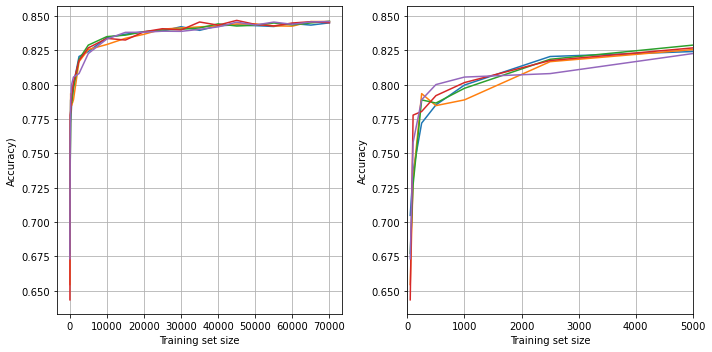

In [30]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)

for i in range(5):
    ax1.plot(results_training_size, k_fold_accuracy[:, i])

ax1.set_xlabel('Training set size')
ax1.set_ylabel('Accuracy)')
ax1.grid()

# Focus on first 5000
ax2 = fig.add_subplot(122)
for i in range(5):
    ax2.plot(results_training_size, k_fold_accuracy[:, i])

ax2.set_xlabel('Training set size')
ax2.set_ylabel('Accuracy')
ax2.set_xlim(0, 5000)
ax2.grid()

plt.tight_layout()
plt.savefig(f'./output/{model_type}_learning_curve.jpg', dpi=300)
plt.show()

## Observations

* Overall accuracy = 84.7% (88.3 for those 69% samples with at least 80% confidence of model)
* Using nominal threshold (50% probability), specificity (89.4%) is greater than sensitivity (74.1%)
* The model can achieve 83.7% sensitivity and specificity simultaneously
* ROC AUC = 0.916
* The model is well calibrated